<a href="https://colab.research.google.com/github/mshsu/data403-project1/blob/main/DataPrep_ClientB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [302]:
!pip install sodapy

In [303]:
import pandas as pd
import holidays
import datetime
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt

# Data Collection

## Liquor Sales

In [304]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
q = """
  select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek, name as StoreName, Zipcode, City, County, category_name, sale_liters, sale_dollars
  LIMIT 50000
"""
results = client.get("m3tr-qhgy", query=q)
df_liquor = pd.DataFrame.from_records(results)

## Colleges

In [305]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

# Data Cleaning

## Functions

In [306]:
us_holidays = holidays.country_holidays('US', years=range(2012, 2024))
def near_holi(date):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [307]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

In [308]:
def classify_college_size(enrollment):
    if enrollment > 10000:
        return "Large"
    elif enrollment > 3000:
        return "Midsize"
    else:
        return "Small"

## Feature Creation/Manipulation

In [309]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges.rename(columns={"Enrollment[7] (spring 2012)": "Enrollment"}, inplace=True)
df_colleges = df_colleges[["Institution", "City", "Enrollment"]]
df_colleges["City"] = df_colleges["City"].str.upper()

In [310]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [311]:
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor.dropna(subset=['City', 'Zipcode', 'County'])

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars
0,2021-08-25T00:00:00.000,8,3,HY-VEE DRUGSTORE / OTTUMWA,52501,OTTUMWA,WAPELLO,SPICED RUM,3.00,60.00
1,2021-08-19T00:00:00.000,8,4,ADVENTURELAND INN,50009,ALTOONA,POLK,IMPORTED FLAVORED VODKA,36.00,1228.68
2,2021-08-26T00:00:00.000,8,4,CLEAR LAKE PAYLESS FOODS,50428,CLEARLAKE,CERRO GORDO,IMPORTED VODKAS,9.00,89.88
3,2021-08-24T00:00:00.000,8,2,HY-VEE / GRIMES,50111,GRIMES,POLK,COCKTAILS/RTD,10.50,85.80
4,2021-08-24T00:00:00.000,8,2,FAREWAY STORES #467 / MARSHALLTOWN,50158,MARSHALLTOWN,MARSHALL,NEUTRAL GRAIN SPIRITS FLAVORED,2.25,45.00
...,...,...,...,...,...,...,...,...,...,...
49995,2021-08-27T00:00:00.000,8,5,HY-VEE FOOD STORE / CLARINDA,51632,CLARINDA,PAGE,FLAVORED RUM,12.00,197.88
49996,2021-08-30T00:00:00.000,8,1,LOT-A-SPIRITS,52722,BETTENDORF,SCOTT,SINGLE MALT SCOTCH,0.75,51.75
49997,2021-08-30T00:00:00.000,8,1,SAC CITY FOOD PRIDE,50583,SAC CITY,SAC,CANADIAN WHISKIES,5.25,65.25
49998,2021-08-30T00:00:00.000,8,1,FAREWAY STORES #888 / JEFFERSON,50129,JEFFERSON,GREENE,COCKTAILS/RTD,10.50,78.66


In [312]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].map(near_holi)
df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type_cat)
df_liquor["CategoryNum"] = df_liquor["Category"].map(
    {
        "VODKA": 1,
        "WHISKY": 2,
        "RUM": 3,
        "GIN": 4,
        "TEQUILA": 5,
        "BRANDY": 6,
        "SCHNAPPS": 7,
        "SPIRITS": 8,
        "OTHER": 9
      })
df_colleges["Student Pop"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
df_colleges["Student Pop"] = df_colleges["Student Pop"].str.replace(",", "").astype(int)
student_pop = pd.DataFrame(df_colleges.groupby("City")["Student Pop"].sum())
college_count = pd.DataFrame(df_colleges.groupby("City")["Institution"].count())
student_pop = student_pop.merge(college_count, how="left", on="City")
student_pop["Size"] = student_pop["Student Pop"].apply(classify_college_size)
student_pop
# !!!Size is from 2012 data!!!
df_liquor = df_liquor.merge(student_pop, how="left", on="City")

In [322]:
df_liquor["Institution"].fillna(0, inplace=True)
df_liquor["Student Pop"].fillna(0, inplace=True)
df_liquor["Size"].fillna("None", inplace=True)

In [325]:
df_liquor["Institution"].value_counts()

0.0    24254
1.0    12302
4.0     7460
3.0     2861
2.0     2061
5.0     1062
Name: Institution, dtype: int64

# Exploration

In [315]:
df_liquor["Category"].value_counts()

WHISKY      13436
VODKA       11996
OTHER        9291
RUM          5079
BRANDY       3041
TEQUILA      2732
SCHNAPPS     2213
GIN          1494
SPIRITS       718
Name: Category, dtype: int64

In [316]:
df_liquor["sale_dollars"].describe()

count    50000.000000
mean       176.148825
std        691.419746
min          1.350000
25%         42.000000
50%         90.000000
75%        169.920000
max      51300.000000
Name: sale_dollars, dtype: float64

In [317]:
df_liquor[df_liquor["sale_dollars"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,CostPerLiter,Category,CategoryNum,Student Pop,Institution,Size


In [318]:
df_liquor["sale_liters"].describe()

count    50000.000000
mean        10.342789
std         55.770451
min          0.020000
25%          1.500000
50%          4.800000
75%         10.500000
max       5670.000000
Name: sale_liters, dtype: float64

In [319]:
df_liquor[df_liquor["sale_liters"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,CostPerLiter,Category,CategoryNum,Student Pop,Institution,Size


In [326]:
df_liquor["Size"].value_counts(normalize=True)

None       0.48508
Large      0.28372
Midsize    0.12598
Small      0.10522
Name: Size, dtype: float64

<Axes: >

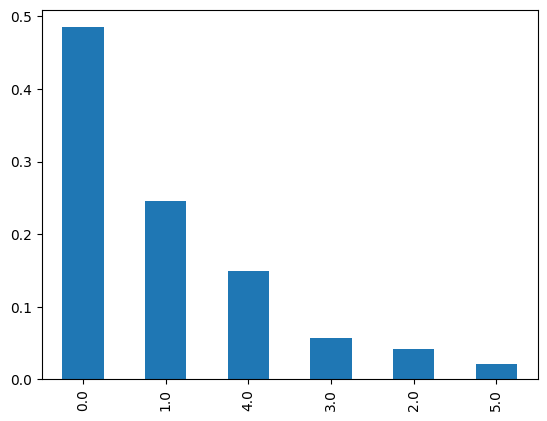

In [328]:
df_liquor["Institution"].value_counts(normalize=True).plot.bar()

# Save Data to CSV

In [329]:
df_liquor.to_csv("client_b", index=False)

# Sources

US Holidays: https://pypi.org/project/holidays/

In [321]:
us_holidays = holidays.country_holidays('US', years=2012)
for day in us_holidays.items():
    print(day)

(datetime.date(2012, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2012, 2, 20), "Washington's Birthday")
(datetime.date(2012, 10, 8), 'Columbus Day')
(datetime.date(2012, 1, 1), "New Year's Day")
(datetime.date(2012, 1, 2), "New Year's Day (Observed)")
(datetime.date(2012, 5, 28), 'Memorial Day')
(datetime.date(2012, 7, 4), 'Independence Day')
(datetime.date(2012, 9, 3), 'Labor Day')
(datetime.date(2012, 11, 11), 'Veterans Day')
(datetime.date(2012, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2012, 11, 22), 'Thanksgiving')
(datetime.date(2012, 12, 25), 'Christmas Day')


Iowa Colleges: https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa